# Multilinear Regression
## ICE 2025 - Artificial Intelligence for O&G Without the Hype

>  - Complete: <a href="https://colab.research.google.com/github/paduapires/aapg_ice/blob/main/Multilinear_regression_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
>
>  - Class: <a href="https://colab.research.google.com/github/paduapires/aapg_ice/blob/main/Multilinear_regression_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

- Pedro Pesce <<pedro_pesce@petrobras.com.br>>
- Thiago Toribio <<thiago.toribio@petrobras.com.br>>
- Cesar Calderon <<cjcalderon@petrobras.com.br>>
- Luiz Eduardo Queiroz <<eduardoqueiroz@petrobras.com.br>>
- Antonio de Padua Pires <<antonio.pires@petrobras.com.br>>

In [44]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.preprocessing as skp
import sklearn.linear_model as skl
import sklearn.metrics as skm
import sklearn.pipeline as skpp

The following function will be useful for plotting the model results:

In [45]:
# creating a colormap for each facies
cmap = {'ANHYDRITE':'magenta', 'SANDSTONE':'xkcd:goldenrod', 'CALCARENITE':'cyan',
        'CALCILUTITE':'xkcd:dark blue', 'DOLOMITE':'purple', 'SHALE':'green',
        'MARL':'xkcd:greenish blue', 'SILTSTONE':'xkcd:reddish orange'}
patchList = [mpatches.Patch(color=value, label=key) for (key,value) in cmap.items()]

def per_facies_scatter(y_hat,y,facies,xlabel=None,ylabel=None,
                       suptitle='',marker='.',linestyle='',cmap=cmap,
                       fig_kwargs=None,plt_kwargs=None,z=None,zlabel='',
                       fontsize=8):
    '''Plots y_hat versus y for each facies'''
    n_groups = len(facies_list)  # uses global facies_list
    labels = ['All'] + facies_list # uses global facies_list

    y_hat = np.asarray(y_hat)
    y = np.asarray(y)
    facies = np.asarray(facies)

    if fig_kwargs is None: fig_kwargs = dict()
    if plt_kwargs is None: plt_kwargs = dict()
    if z is None: z = np.arange(y_hat.size)

    nlin = int(np.floor(np.sqrt(n_groups+1)))
    ncol = int(np.ceil(n_groups/nlin))
    fig,axs = plt.subplots(nlin,ncol+1,sharex='all',sharey='all',
                           gridspec_kw={'wspace':0,'hspace':0},
                           figsize=(7,5),**fig_kwargs)
    gs = axs[0, -1].get_gridspec() # Making a large subplot on the right
    for ax in axs[:, -1]:
        ax.remove()
    axs = axs[:,:-1]
    axbig = fig.add_subplot(gs[:,-1])

    mM = min([y_hat.min(),y.min()]) , max([y_hat.max(),y.max()])
    # Plotting the well log
    axbig.plot(y,z,label='Measured')
    axbig.plot(y_hat,z,label='Predicted',alpha=0.5)
    axbig.legend(fontsize=fontsize); axbig.set_ylabel(zlabel,rotation=270)
    axbig.invert_yaxis(); axbig.grid(); axbig.yaxis.tick_right()
    axbig.yaxis.set_label_position("right")
    xlim = axbig.get_xlim()
    dx = np.diff(xlim)*0.03
    axbig.set_xlim(xlim) # xlim no longer dynamic after this
    for fac in facies_list:
        mask = facies==fac
        if not mask.any():
            continue
        axbig.fill_betweenx(z,xlim[-1],xlim[-1]-dx,
                            where=mask,color=cmap.get(fac,'C0'),step='mid')

    for i,(ax,label) in enumerate(zip(axs.flat,labels)):
        ax.plot(mM,mM,'k--'), ax.grid()
        if i == 0: # All points
            mask = np.full(y_hat.shape,True)
        else:
            mask = facies==label
        if not mask.any(): # if there are no points in the class, skip it
            continue
        y_hat_mask,y_mask = y_hat[mask],y[mask]
        MSE = ((y_hat_mask-y_mask)**2).mean()
        RMSE = np.sqrt(MSE)
        R2 = 1 - MSE/y.var()
        color = cmap.get(label,'C0')
        ax.plot(y_hat_mask,y_mask,marker=marker,linestyle=linestyle,color=color,
                label=f'{label}\n{RMSE=:.2f}\n{R2=:.3f}',**plt_kwargs)
        ax.legend(fontsize=fontsize)
    if xlabel:
        axs[-1     ,ncol//2].set_xlabel(xlabel)
    if ylabel:
        axs[nlin//2,0      ].set_ylabel(ylabel)
    fig.suptitle(suptitle)
    plt.tight_layout()
    return fig,axs


## Getting the data

The file `https://github.com/paduapires/aapg_ice/raw/main/well_logs.xlsx` contains a dataset composed of well log data for 2 wells, with columns for:
- Well number: **well**
- Depth (m): **z**
- Gamma ray ($^\circ$API): **gr**
- Density ($g/cm^3$): **rho**
- Neutron porosity (.dec): **nphi**
- Compressional slowness ($\mu s/ft$): **dt_p**
- Shear slowness ($\mu s/ft$): **dt_s**
- Facies: **facies**

A planned future well will not measure **dt_s**. Our task is to develop a model that estimates **dt_s** (our **target**) from other available data (**features**).

Since the task is **predicting** (or **inferring**) a **continuous** value (and not a **categorical** one), this is a **regression** task.

Since our models will use available measurements of the target value in order to learn how to map input features to the desired target outputs, this a **supervised** experiment.

In [46]:
# Construct the raw file URL for the Excel file on GitHub
excel_url = 'https://github.com/paduapires/aapg_ice/raw/main/well_logs.xlsx'

# Use pandas to read the Excel file directly from the raw URL
df = pd.read_excel(io=excel_url, engine='openpyxl')
display(df.sample(10))

,well,z,gr,rho,nphi,dt_p,dt_s,facies
23801,well_1,3297.174118,134.622757,2.425619,27.755701,97.333423,210.134614,SHALE
27743,well_1,3897.934918,101.308197,2.464619,7.741486,71.250058,124.653818,SANDSTONE
18486,well_1,2487.168118,83.505600,2.329062,25.119084,104.994301,228.712634,MARL
15566,well_0,4267.200172,75.138840,2.341082,23.697329,83.382058,153.547157,SANDSTONE
29729,well_1,4200.601318,115.507584,2.440255,11.757842,71.139289,129.513420,SANDSTONE
27437,well_1,3851.300518,100.037231,2.370111,19.256905,80.497594,143.995368,SANDSTONE
32204,well_1,4577.791318,133.348572,2.550493,2.105667,59.672940,101.547698,SANDSTONE
5958,well_0,2802.940972,74.953476,2.163653,29.515611,118.597780,314.195887,SANDSTONE
14923,well_0,4169.206972,51.797920,2.403617,27.585552,89.047189,164.261614,SHALE
5941,well_0,2800.350172,67.106018,2.146315,30.647912,128.944733,338.426448,SANDSTONE


In [47]:
# eliminating lines with incomplete data
df = df.dropna() # YOUR CODE HERE to drop lines with NaN
df.sample(10)

,well,z,gr,rho,nphi,dt_p,dt_s,facies
9468,well_0,3337.864972,78.679367,2.218701,29.029689,88.233024,193.671000,SANDSTONE
26579,well_1,3720.541318,152.125641,2.460380,22.724808,93.407770,174.625129,SHALE
13567,well_0,3962.552572,71.673676,2.445123,28.834858,94.638327,180.699533,SHALE
21139,well_1,2891.485318,81.723587,2.159796,27.135707,112.220785,236.009438,SHALE
6030,well_0,2813.913772,60.564560,2.042238,38.824077,128.347485,363.288984,SANDSTONE
16820,well_0,4458.309772,73.710480,2.582984,17.876514,74.347904,142.333125,CALCARENITE
22342,well_1,3074.822518,113.684380,2.324603,30.164334,108.420528,238.107547,SHALE
10780,well_0,3537.813772,83.277802,2.272865,31.089190,89.149504,179.940245,SANDSTONE
6340,well_0,2861.157772,64.464508,2.074436,34.807950,124.264159,340.142539,SANDSTONE
5551,well_0,2740.914172,70.488831,2.076487,38.930018,126.800046,358.511180,SANDSTONE


### Exploratory data analysis

Columns `well` and `facies` contain **categorical** data. Counting the ocurrence of each is an easy way to start the analysis.

In [48]:
df_counts = df[['well','facies']].value_counts().to_frame().transpose()
df_counts[df_counts.columns.sort_values()]

well      well_0                                                         \
facies ANHYDRITE CALCARENITE CALCILUTITE DOLOMITE  MARL SANDSTONE SHALE   
count        114        1091         615       69  1170      5500  4986   

well                  well_1                                       
facies SILTSTONE CALCILUTITE  MARL SAND SANDSTONE SHALE SILTSTONE  
count        134          93  1680    7      6066  6052       453

The `'SAND'` facies has very few examples. Let's merge them into the `'SANDSTONE'` facies:

In [49]:
sand_mask = df['facies']=='SAND'  # YOUR CODE HERE to make a logical mask that selects only SAND
df.loc[sand_mask,'facies'] = 'SANDSTONE' # changing values in a DataFrame can be finicky...
df['facies'].value_counts().to_frame().transpose()

facies,SANDSTONE,SHALE,MARL,CALCARENITE,CALCILUTITE,SILTSTONE,ANHYDRITE,DOLOMITE
count,11573,11038,2850,1091,708,587,114,69


In [50]:
facies_list = list(df['facies'].unique())
print(facies_list)

['SANDSTONE', 'MARL', 'SHALE', 'CALCILUTITE', 'SILTSTONE', 'CALCARENITE', 'ANHYDRITE', 'DOLOMITE']


The other columns contain continuous data. Let's visualize how each **feature** correlates to the **target** variable **dt_s**:

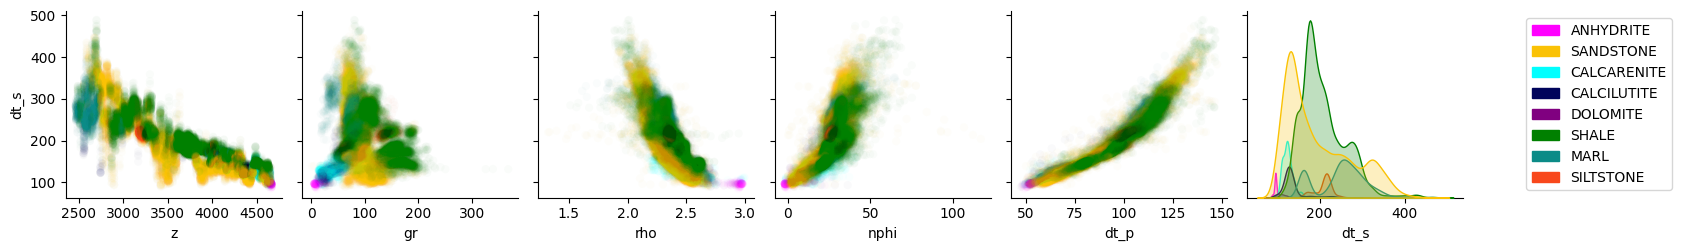

In [51]:
g = sns.pairplot(data=df,x_vars=df. columns[1:-1],y_vars=['dt_s'], hue='facies',
             plot_kws={'alpha':0.02,'edgecolor':'none'},palette=cmap)
# Legend markers are too transparent. Fix that
g._legend.remove()
plt.legend(handles=patchList,bbox_to_anchor=(2, 1),ncol=1)
plt.show() # lots of points, takes a few seconds....

### Feature selection and Dataset splitting

As domain experts, it is our responsibility to choose the best features as inputs to the regression models, being mindful not only that the selected features are truly informative for estimating the target, but also that these choices will impact the future applicability of the model, since all input features must be available in future wells for the inference to be possible.

We will use the more diverse `well_0` as a **training dataset**, to  **optimize** the **loss function** and obtain the optimum **model parameters** for several models.

The **validation dataset** `well_1` will be used to **select the best model** for future use.


## **Discussion question**

Would a **random selection** of examples from **both wells** be an appropriate train/validation splitting strategy? Why?

In [52]:
features = [ 'rho' , 'nphi' , 'dt_p' ] # YOUR CODE HERE. Should we use 'z'? 'What about 'nphi'?
target = 'dt_s'

mask_train = df['well']=='well_0'  # logical maks
mask_validation = ~mask_train

df_train = df[mask_train]
df_validation = df[mask_validation]

X_train = df_train[features]
y_train = df_train[target]

X_validation = df_validation[features]
y_validation = df_validation[target]

# Multilinear Regression

One of the simplest and most flexible models for predicting continuous outcomes is the multilinear regression model:

$$y_i \approx \hat{y}_i = w_0 + w_1 x_{i1} + w_2 x_{i2} + \cdots + w_M x_{iM} = \vec{x}_i\cdot \vec{w}
$$

Where $y_i$ is the *ground truth* for the *target* variable of the $i$-th example, which we would like to predict based on its $M$ known **features** $x_{ij}$ ($j=1,2,\dots,M$). The **prediction** $\hat{y}_i$ is simply a linear combination of the **features**.


Each example is represented by its (augmented) *feature vector* $\vec{x}_i$, where we define $x_{i0}=1$ for all examples, so the **inference** step can be written as a single dot product between the **feature vector** ($\vec{x}_i$) and the **weight vector** ($\vec{w}$).

$$
\vec{x}_i = \begin{bmatrix} 1 \\ x_{i1} \\ \vdots \\ x_{iM}
\end{bmatrix} \qquad ; \qquad
\vec{w} = \begin{bmatrix} w_0
 \\ w_1 \\ \vdots \\ w_M
\end{bmatrix}
$$

The model **parameters** $w_j$ are known as its **weights** ($w_j$, for $j\geq1$) and **bias** ($w_0$).

It is common to organize the entire dataset of $N$ examples in a matrix $X$ of dimensions $N\times M+1$ like so:

$$X = \begin{bmatrix} \vec{x}_1^T \\ \vec{x}_2^T \\ \vdots \\ \vec{x}_N^T
\end{bmatrix} = \begin{bmatrix}
1 & x_{11} & x_{12} & \cdots & x_{1M} \\
1 & x_{21} & x_{22} & \cdots & x_{2M} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
1 & x_{N1} & x_{N2} & \cdots & x_{NM} \\
\end{bmatrix}
$$

where each line represents a different example, and each column is a different feature, including the constant $1$ feature. This way, the multilinear model can be written as a single matrix equation:

$$
X\vec{w} = \vec{\hat{y}} \qquad ; \qquad \vec{\hat{y}} \approx \vec{y}
$$

It is important to choose an **objective function** (also called a **loss function**) that expresses mathematically how good the model is. The most common objetive function is the **Sum of Squared Errors**:

$$
SSE = \sum_{i=1}^N \left( \hat{y}_i - y_i \right)^2 = \lVert \vec{\hat y} - \vec{y} \rVert^2 = \lVert X\vec{w} - \vec{y} \rVert^2
$$

The problem of obtaining the best parameters can then be written as:

$$
\underset{\vec{w}}{\text{argmin}} \quad  \lVert X\vec{w} - \vec{y} \rVert^2
$$

This particular problem has a closed form analytical solution given by solving the so-called normal equations:

$$\begin{align}
X^TX\vec{w} = &X^T\vec{y}\\
\vec{w} = & \left(X^TX\right)^{-1}X^T\vec{y}
\end{align}
$$

### Degree 1 model - Numpy

There are several methods for solving the normal equations. One of the most widely used packages for these kinds of linear algebra is `numpy.linalg`, which implements the function `np.linalg.lstsq`:

Optimum bias and weights: w1 = array([-15.64247265, -42.44935114,  -1.13052335,   3.69968597])


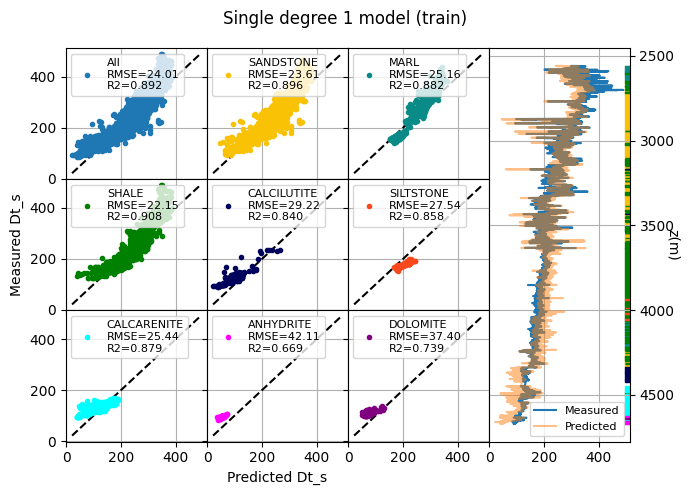

In [53]:
X1_train = np.column_stack([np.ones(X_train.shape[0]), X_train]) # Adding a column of the constant 1 feature

w1,*_ = np.linalg.lstsq( X1_train, y_train) # YOUR CODE HERE. Solving the least squares problem, TRAINING the model
print(f'Optimum bias and weights: {w1 = }')

y_hat1_train = X1_train @ w1 # YOUR CODE HERE. Using the model, running INFERENCE on the TRAINING SET


xlabel = 'Predicted Dt_s'
ylabel = 'Measured Dt_s'
per_facies_scatter(y_hat1_train, y_train, df_train['facies'],
                   xlabel=xlabel, ylabel=ylabel, suptitle='Single degree 1 model (train)',
                   z=df_train['z'],zlabel='z(m)');

### Validation dataset

However, we are interested in how well the model performs when presented with data it has never seen before:

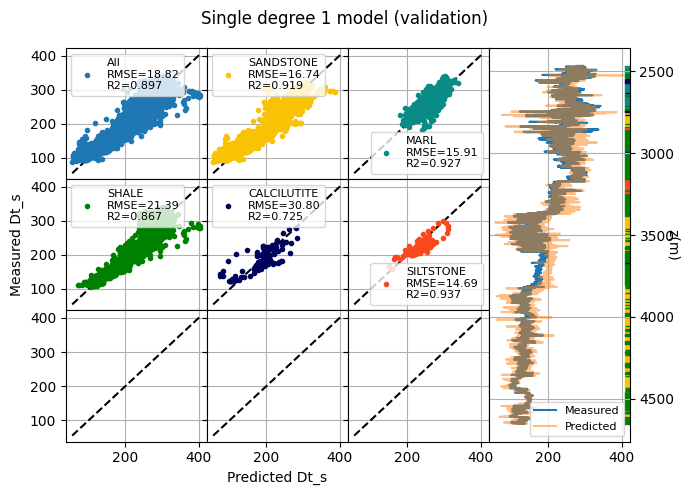

In [54]:
X1_validation = np.column_stack([np.ones(X_validation.shape[0]), X_validation]) # Adding a column of the constant 1 feature
y_hat1_validation = X1_validation @ w1 # YOUR CODE HERE. Using the model, running INFERENCE on the VALIDATION DATASET

per_facies_scatter(y_hat1_validation, y_validation, df_validation['facies'],
                   xlabel=xlabel, ylabel=ylabel, suptitle='Single degree 1 model (validation)',
                   z=df_validation['z'],zlabel='z(m)');

### Degree 1 model - Scikit-learn

For ML tasks, the `sklearn` module implements many of the most widely used models. Linear Regression is available via `skl.LinearRegression`, which implements the methods `.fit` and `.predict`.

The model parameters are stored in the attributes `.intercept_` and `.coef_`. The presence of these attributes in sklearn estimators indicates if the estimator has already been trained. By convention, variables which end with an underscore (`_`) are supposed to only be used internally, so be careful with those.

In [55]:
model1 = skl.LinearRegression(fit_intercept=True) # instantiating the model
model1.fit(X_train, y_train) # TRAINING the model. No need to add the 1 column because fit_intercept=True handles that for us

# Verifying the parameters are the same ones we found earlier
print(f'''numpy:
 {w1 = }

sklearn:
 {model1.intercept_ = }
 {model1.coef_ = }''')

numpy:
 w1 = array([-15.64247265, -42.44935114,  -1.13052335,   3.69968597])

sklearn:
 model1.intercept_ = np.float64(-15.64247265229696)
 model1.coef_ = array([-42.44935114,  -1.13052335,   3.69968597])


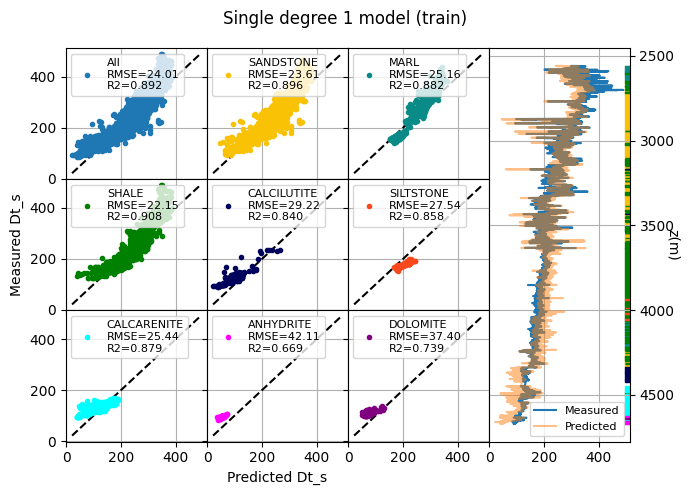

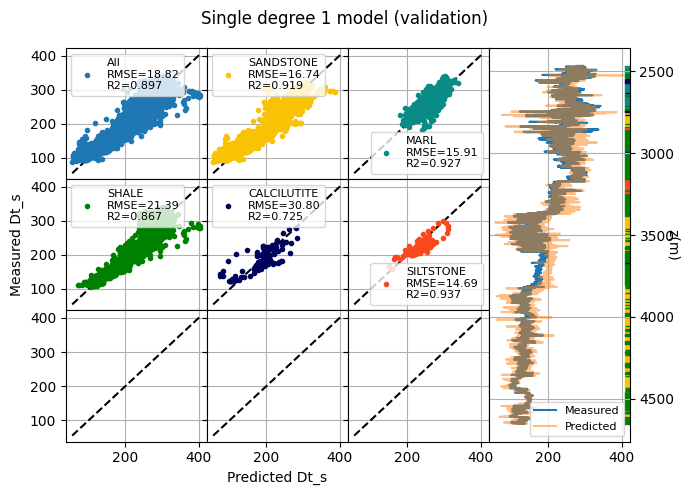

In [56]:
y_hat1_train = model1.predict(X_train) # Running INFERENCE on the TRAINING SET
y_hat1_validation = model1.predict(X_validation) # YOUR CODE HERE to run inference on the VALIDATION SET

per_facies_scatter(y_hat1_train, y_train, df_train['facies'],
                   xlabel=xlabel, ylabel=ylabel, suptitle='Single degree 1 model (train)',
                   z=df_train['z'],zlabel='z(m)');
per_facies_scatter(y_hat1_validation, y_validation, df_validation['facies'],
                   xlabel=xlabel, ylabel=ylabel, suptitle='Single degree 1 model (validation)',
                   z=df_validation['z'],zlabel='z(m)');

## Underfitting and Feature engineering

It seems the model consistently underestimates the target variable on some regions of the data range, while overestimating it around others, even for data it was trained on. This behaviour is called **underfitting**, and is typical of models that are insuficiently flexible, unable to capture more complex dependencies between the input features and the target variable.

The target variable **dt_s** might have a nonlinear dependence on the input variables. One way to account for that is by creating new features from nonlinear combination of the original features. These new features can be handcrafted by using specialist domain knowledge, or simply generated from a stock of premade recipes.

A common way of achieving this is by creating **polynomial features** of up to degree $N$ (a **hyperparameter**, which is chosen by the scientist, not optimized by the loss function). This functionality is available via `skp.PolynomialFeatures`, which implements the `.fit` and `.transform` methods.

In [57]:
poly = skp.PolynomialFeatures(degree=3) # change the maximum degree to see what happens
poly.fit(X_train)  # there are NO learned parameters here. The fit method only binds the names of the features to apply the transformation
X_poly = poly.transform(X_train) # .transform applies the transformation

pd.DataFrame(X_poly,columns=poly.get_feature_names_out()).sample(3)

,1,rho,nphi,dt_p,rho^2,rho nphi,rho dt_p,nphi^2,nphi dt_p,dt_p^2,rho^3,rho^2 nphi,rho^2 dt_p,rho nphi^2,rho nphi dt_p,rho dt_p^2,nphi^3,nphi^2 dt_p,nphi dt_p^2,dt_p^3
8956,1.0,2.401898,32.330556,100.196065,5.769116,77.654710,240.660768,1045.264849,3239.394501,10039.251532,13.856830,186.518722,578.042708,2510.619949,7780.696412,24113.262016,33793.993680,104731.425189,324574.583456,1.005894e+06
3514,1.0,2.168892,33.635554,109.336644,4.704093,72.951890,237.139391,1131.350494,3677.598591,11954.501688,10.202671,158.224783,514.329769,2453.777232,7976.314797,25928.025140,38053.600667,123698.066064,402096.287334,1.307065e+06
11105,1.0,2.367616,33.996609,91.174148,5.605607,80.490925,215.865397,1155.769427,3099.611873,8312.725306,13.271926,190.571623,511.086426,2736.418502,7338.691508,19681.343701,39292.241358,105376.293054,282604.472384,7.579056e+05


### Pipeline

Since all data that goes into our model will have to go through the **same preprocessing and feature engineering** steps before being passed throught to the linear regressor, it is convenient to store all these steps into a single `skpp.Pipeline` object, which automates this chain of compositions. These can easily be created with the `skpp.make_pipeline` convenience function.


In [58]:
pipe2 = skpp.make_pipeline(
    skp.PolynomialFeatures(degree=2, include_bias=False), # no need to create the constant column, since the LinearRegression handles that
    skl.LinearRegression() )
pipe2

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

`skpp.Pipeline` objects also have the `.fit`, `.transform` and `.predict` methods, which are run sequentially on each of its steps.

In [59]:
pipe2.fit(X_train, y_train)  # YOUR CODE HERE. Training the model on the TRAINING SET
pipe2

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(include_bias=False)),
                ('linearregression', LinearRegression())])

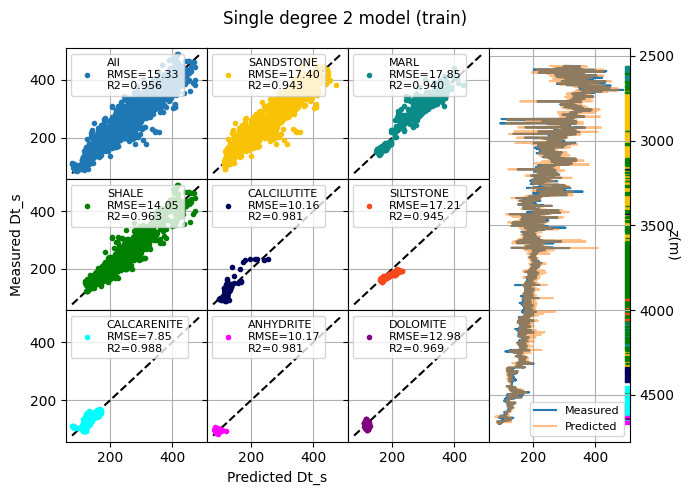

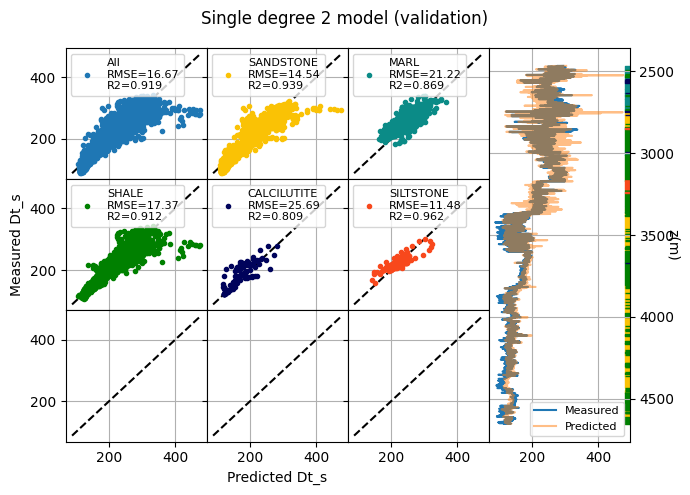

In [60]:
y_hat2_train = pipe2.predict(X_train) # YOUR CODE HERE to apply the pipeline to the TRAINING SET
y_hat2_validation = pipe2.predict(X_validation)  # YOUR CODE HERE to apply the pipeline to the VALIDATION SET

deg = pipe2['polynomialfeatures'].degree # each step of the pipeline can be accessed via its name, if needed

per_facies_scatter(y_hat2_train, y_train, df_train['facies'],
                   xlabel=xlabel, ylabel=ylabel, suptitle=f'Single degree {deg} model (train)',
                   z=df_train['z'],zlabel='z(m)');
per_facies_scatter(y_hat2_validation, y_validation, df_validation['facies'],
                   xlabel=xlabel, ylabel=ylabel, suptitle=f'Single degree {deg} model (validation)',
                   z=df_validation['z'],zlabel='z(m)');

## Specialized models for each facies

The model's performance varies across each facies, performing better on some classes than on others. Since some facies are underrepresented in the dataset, the single model we created is not incentivized to accurately predict **dt_s** for these rare facies. It is often worth it to create specialized models for each facies (or group of facies).

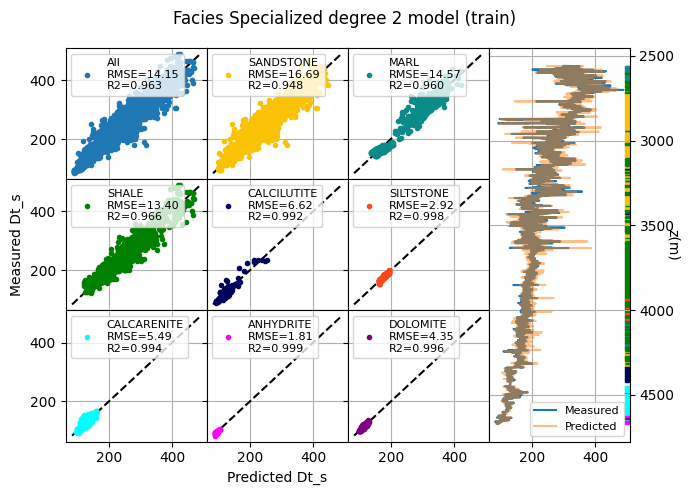

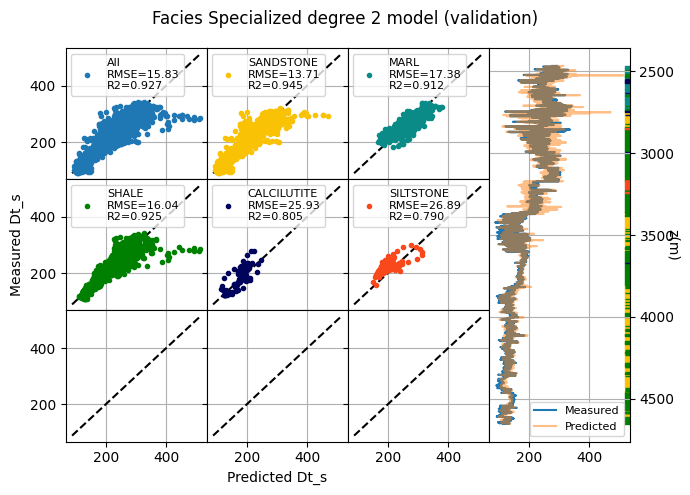

In [61]:
pipes3 = dict() # initializing an empty dict

# Training data set
y_hat3_train = 0*y_train # initializing a zeroed vector of predictions
for fac in facies_list:
    fac_pipe = skpp.make_pipeline(skp.PolynomialFeatures(degree=2,include_bias=False),
                               skl.LinearRegression()
                                     )
    mask_fac_train = df_train['facies'] == fac # logical mask
    fac_pipe.fit(X_train[mask_fac_train],y_train[mask_fac_train]) # training only on the relevant facies
    pipes3[fac] = fac_pipe # storing the pipeline for later use

    y_hat3_train[mask_fac_train] = pipes3[fac].predict(X_train[mask_fac_train])

# Validation data set
y_hat3_validation = 0*y_validation # initializing a zeroed vector of predictions
for fac in facies_list:
    mask_fac_validation = df_validation['facies'] == fac # logical mask
    if not mask_fac_validation.any():
       continue # if there are no data points of the given facies, no need to run the model
    y_hat3_validation[mask_fac_validation] = pipes3[fac].predict(X_validation[mask_fac_validation]) # YOUR CODE HERE

per_facies_scatter(y_hat3_train, y_train, df_train['facies'],
                   xlabel=xlabel, ylabel=ylabel,
                   suptitle=f'Facies Specialized degree {fac_pipe['polynomialfeatures'].degree} model (train)',
                   z=df_train['z'],zlabel='z(m)');
per_facies_scatter(y_hat3_validation, y_validation, df_validation['facies'],
                   xlabel=xlabel, ylabel=ylabel,
                   suptitle=f'Facies Specialized degree {fac_pipe['polynomialfeatures'].degree} model (validation)',
                   z=df_validation['z'],zlabel='z(m)');

### Overfitting

It might be reasonable to assume that a more specialized model, or one with more adjustable parameters, will be able to fit the data more closely. While that is true of the **training set**, it might not be so for novel data (represented here by the **validation set**). If it is the case that the model performance is good on the training data, but is significantly worse for novel data, we say that the model does **not generalize** well, it **overfits** the training data.

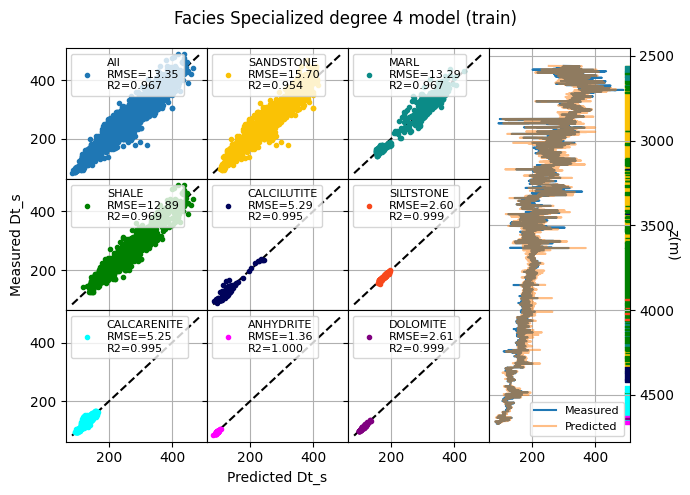

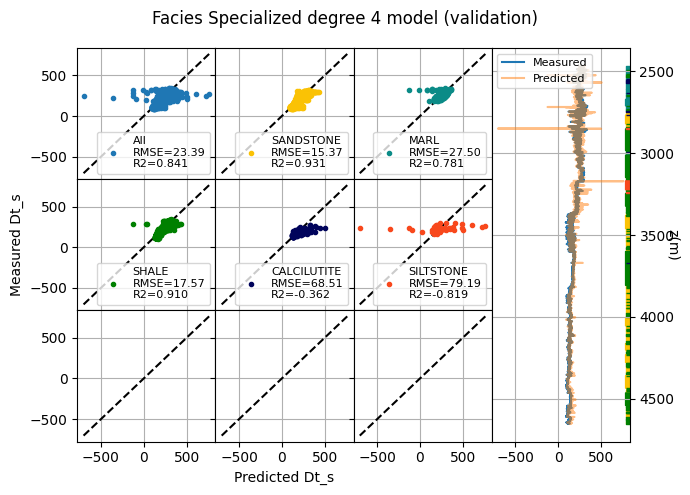

In [62]:
pipes4 = dict() # initializing an empty dict of models

# Training data set
y_hat4_train = 0*y_train # initializing a zeroed vector of predictions
for fac in facies_list:
    fac_pipe = skpp.make_pipeline(skp.PolynomialFeatures(degree=4,include_bias=False), # Try several degrees
                               skl.LinearRegression()
                                     )
    mask_fac_train = df_train['facies'] == fac # logical mask
    fac_pipe.fit(X_train[mask_fac_train],y_train[mask_fac_train]) # training only on the relevant facies
    pipes4[fac] = fac_pipe # storing the pipeline for later use

    y_hat4_train[mask_fac_train] = pipes4[fac].predict(X_train[mask_fac_train])

# Validation data set
y_hat4_validation = 0*y_validation # initializing a zeroed vector of predictions
for fac in facies_list:
    mask_fac_validation = df_validation['facies'] == fac # logical mask
    if not mask_fac_validation.any():
       continue # if there are no data points of the given facies, no need to run the model
    y_hat4_validation[mask_fac_validation] = pipes4[fac].predict(X_validation[mask_fac_validation]) # YOUR CODE HERE

per_facies_scatter(y_hat4_train, y_train, df_train['facies'],
                   xlabel=xlabel, ylabel=ylabel,
                   suptitle=f'Facies Specialized degree {fac_pipe["polynomialfeatures"].degree} model (train)',
                   z=df_train['z'],zlabel='z(m)');
per_facies_scatter(y_hat4_validation, y_validation, df_validation["facies"],
                   xlabel=xlabel, ylabel=ylabel,
                   suptitle=f'Facies Specialized degree {fac_pipe["polynomialfeatures"].degree} model (validation)',
                   z=df_validation['z'],zlabel='z(m)');

There are many metrics we can use to judge model performance. Many of them are implemented in `sklearn.metrics` (and there are many more which are not).

The best performing model (along with all preprocessing steps) as measured by the performance on the **validation dataset** should be stored for later use.

The best practice is to also do a unbiased estimation of its performance on a proxy of future data, that is, neither the training set (which is biased since it was used for parameter optimization), nor the validation set (which is biased since it was used for hyperparameter tuning). This extra **holdout data** is usually called the **test set**, though some sources reverse the use of "validation" and "test", and some others use them interchangeably.

$$\begin{align}
MSE & = \frac{1}{N}\sum_{i=1}^N \left(\hat{y}_i - y_i \right)^2\\
RMSE & = \sqrt{\frac{1}{N}\sum_{i=1}^N \left(\hat{y}_i - y_i \right)^2} \\
MAE & = \frac{1}{N}\sum_{i=1}^N \lvert\hat{y}_i - y_i \rvert \\
R^2 & = 1 - \frac{\displaystyle\sum_{i=1}^N\left(\hat{y}_i - y_i \right)^2}{\displaystyle\sum_{i=1}^N\left(\bar{y} - y_i \right)^2} \quad ; \quad \bar{y} = \frac{1}{N}\sum_{i=1}^Ny_i
\end{align}
$$

In [63]:
#                                                 sklearn                                                 numpy
print('Mean Squared Error (train)      :',skm.mean_squared_error(y_train,y_hat4_train), ' ; ', np.mean((y_train-y_hat4_train)**2))
print('Mean Squared Error (validation) :',skm.mean_squared_error(y_validation,y_hat4_validation ))
print()
print('Root Mean Squared Error (train)      :',np.sqrt(skm.mean_squared_error(y_train,y_hat4_train)))
print('Root Mean Squared Error (validation) :',np.sqrt(skm.mean_squared_error(y_validation,y_hat4_validation )))
print() #                                        sklearn                                                   numpy
print('Mean Absolute Error (train)      :',skm.mean_absolute_error(y_train,y_hat4_train),' ; ', np.mean(np.abs(y_train-y_hat4_train)))
print('Mean Absolute Error (validation) :',skm.mean_absolute_error(y_validation,y_hat4_validation ))
print() #                                        sklearn                                          numpy
print('R2 (train)      :',skm.r2_score(y_train,y_hat4_train), ' ; ', 1 - np.mean((y_train-y_hat4_train)**2)/np.mean((y_train-y_train.mean())**2))
print('R2 (validation) :',skm.r2_score(y_validation,y_hat4_validation ))
print()
print('Max Absolute Error (train)      :', np.max(np.abs(y_train-y_hat4_train)))
print('Max Absolute Error (validation) :', np.max(np.abs(y_validation-y_hat4_validation)))
print()
print(f'Percentage Abs Error < 10us/ft (train)     : {(np.abs(y_train-y_hat4_train)<10).mean():.2%}')
print(f'Percentage Abs Error < 10us/ft (validation): {(np.abs(y_validation-y_hat4_validation)<10).mean():.2%}')


Mean Squared Error (train)      : 178.31471780603025  ;  178.31471780603025
Mean Squared Error (validation) : 546.9342000335693

Root Mean Squared Error (train)      : 13.353453403746547
Root Mean Squared Error (validation) : 23.386624383043596

Mean Absolute Error (train)      : 8.846610394892494  ;  8.846610394892494
Mean Absolute Error (validation) : 12.826933404949669

R2 (train)      : 0.9666677382114278  ;  0.9666677382114278
R2 (validation) : 0.8413089441897263

Max Absolute Error (train)      : 140.62621585654776
Max Absolute Error (validation) : 943.3870217434118

Percentage Abs Error < 10us/ft (train)     : 70.43%
Percentage Abs Error < 10us/ft (validation): 56.73%
